In [109]:
import pandas as pd
import numpy as np
import cvxpy as cp
import scipy.stats as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [146]:
# Load the data
asset1 = pd.read_csv('sorted_commodities_returns.csv')
asset2 = pd.read_csv('etfarb.csv')
asset3 = pd.read_csv('cumulative_strategy_returns.csv')

# Convert the 'Date' column to datetime to ensure proper merging
asset1['Date'] = pd.to_datetime(asset1['Date'])
asset2['Date'] = pd.to_datetime(asset2['Date'])
asset3['Date'] = pd.to_datetime(asset3['Date'])

asset1 = asset1.set_index('Date')
asset1 = asset1.reindex(asset2['Date'], fill_value=0)
asset2 = asset2.set_index('Date')
asset3 = asset3.set_index('Date')

# Merge the dataframes on 'Date'
data_merged = pd.merge(pd.merge(asset1, asset2, on='Date', suffixes=('_asset1', '_asset2')), asset3, on='Date')
data_merged.rename(columns={'Total_returns': 'Total_returns_asset3'}, inplace=True)
# data_merged = data_merged.set_index('Date')

# Print the merged DataFrame to ensure it looks correct
START_DATE = '2016'
data_merged = data_merged[START_DATE:]
display(data_merged)

,Total_returns_asset1,Total_returns_asset2,Total_returns_asset3
Date,,,
2016-01-04,0.0,0.219533,-0.005516
2016-01-05,0.0,0.222181,-0.005516
2016-01-06,0.0,0.220945,-0.006016
2016-01-07,0.0,0.216848,0.017943
2016-01-08,0.0,0.213216,0.017943
...,...,...,...
2023-03-27,0.0,0.510203,-0.258650
2023-03-28,0.0,0.509775,-0.261120
2023-03-29,0.0,0.503630,-0.261620


In [147]:
from metrics import annualized_return, annualized_sharpe_ratio, annualized_volatility
print(annualized_return(asset2))
print(annualized_volatility(asset2))
print(annualized_sharpe_ratio(asset2))

Total_returns    56.43087
dtype: float64
Total_returns    2.253017
dtype: float64
Total_returns    25.046804
dtype: float64


In [164]:
# Calculate mean returns and covariance matrix
mu = (data_merged[['Total_returns_asset1', 'Total_returns_asset2', 'Total_returns_asset3']].mean()).to_numpy()
Sigma = data_merged[['Total_returns_asset1', 'Total_returns_asset2', 'Total_returns_asset3']].cov().to_numpy()
print('--------')
print(type(mu))
print(Sigma.shape)
display(mu, Sigma)

--------
<class 'numpy.ndarray'>
(3, 3)


array([ 0.        ,  0.32827657, -0.03205333])

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00774446, -0.00386364],
       [ 0.        , -0.00386364,  0.0061976 ]])

In [165]:
# Long only portfolio optimization.

n = 2

w = cp.Variable(n)
mu = mu[1:]
Sigma = Sigma[1:,1:]
print(mu, Sigma)
gamma = cp.Parameter(nonneg=True)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0])
print(prob)
SAMPLES = 50
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = np.zeros((SAMPLES, 2))
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value
    w_vals[i] = w.value
# ret_series = data_merged @ w_vals.T
# display(ret_series)

[ 0.32827657 -0.03205333] [[ 0.00774446 -0.00386364]
 [-0.00386364  0.0061976 ]]
maximize [ 0.32827657 -0.03205333] @ var2766 + -param2767 @ QuadForm(var2766, [[0.01 -0.00]
 [-0.00 0.01]])
subject to Sum(var2766, None, False) == 1.0
           0.0 <= var2766


In [161]:
# print(gamma_vals)
# print(risk_data)
# print(ret_data)
# print(w_vals)
pd.DataFrame(zip(gamma_vals, w_vals[:,0], w_vals[:,1], w_vals[:,1], ret_data, risk_data, ret_data/risk_data), columns=['Gamma', 'Asset 1 Weight', 'Asset 2 Weight', 'Asset 3 Weight', 'Return', 'Risk', 'Return/Risk']).set_index('Gamma')

,Asset 1 Weight,Asset 2 Weight,Asset 3 Weight,Return,Risk,Return/Risk
Gamma,,,,,,
0.010000,1.000000,-2.220426e-22,-2.220426e-22,0.328277,0.088003,3.730305
0.012649,1.000000,-1.110198e-22,-1.110198e-22,0.328277,0.088003,3.730305
0.015999,1.000000,1.110254e-22,1.110254e-22,0.328277,0.088003,3.730305
0.020236,1.000000,1.110263e-22,1.110263e-22,0.328277,0.088003,3.730305
0.025595,1.000000,5.000951e-27,5.000951e-27,0.328277,0.088003,3.730305
0.032375,1.000000,6.319011e-27,6.319011e-27,0.328277,0.088003,3.730305
0.040949,1.000000,7.983464e-27,7.983464e-27,0.328277,0.088003,3.730305
0.051795,1.000000,1.008328e-26,1.008328e-26,0.328277,0.088003,3.730305
0.065513,1.000000,1.273183e-26,1.273183e-26,0.328277,0.088003,3.730305


In [152]:
for col in ret_series:
    col = ret_series[col]
    print(annualized_return(col), annualized_sharpe_ratio(col))

82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59.2167569064843
82.72569662547005 59

1.0985411419875584
7.196856730011521
18.420699693267164
120.67926406393289


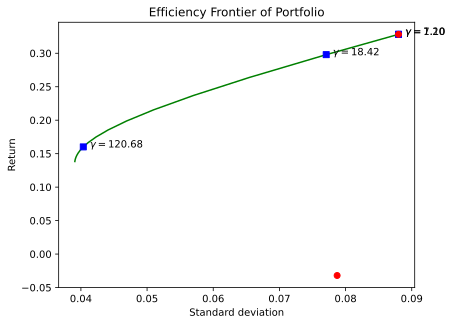

In [162]:
# Plot long only trade-off curve.

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [20, 28, 32, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, "g-")
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], "bs")
    ax.annotate(
        r"$\gamma = %.2f$" % gamma_vals[marker],
        xy=(risk_data[marker] + 0.001, ret_data[marker] - 0.001),
    )
    print(gamma_vals[marker])
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i, i]).value, mu[i], "ro")
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.title("Efficiency Frontier of Portfolio")
plt.show()